__Customer Lifetime Value Prediction__<br></br>
Companies invest in customers through offline ads, promotions, discount etc. in order to 
increase revenue and profitability. However, there are some customers who prove to be super valuable while some customers pulls 
the profitability down.<br></br>
__Customer Lifetime Value = Total Gross Revenue generated by that customer - Total Cost incurred on that customer__

For calculating Customer LTV we need to decide a time window first (can be 3,4,6,12 months). The above equation gives Customer 
LTV in a specific time window. Steps to predict customer LTV:-<br></br>
- Decide a specific time frame for which customer LTV need to be calculated.
- Decide the features to be used for predicting the future customer LTV.
- Calculate LTV for training the machine learning model
- Build and Run the ML Model
- Check if the model is useful or not.
Time frame for which you need to calculate the LTV depends on the industry,business model and startegy.
We will calculate 6 months LTV.

In [1]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data = pd.read_csv("OnlineRetail.csv",encoding='latin1')
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [3]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data_uk = pd.DataFrame(data.query("Country=='United Kingdom'").reset_index(drop=True))
data_3m = data_uk[(data_uk.InvoiceDate < datetime(2011,6,1)) & (data_uk.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True)
data_6m = data_uk[(data_uk.InvoiceDate >= datetime(2011,6,1)) & (data_uk.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)

In [4]:
data_user = pd.DataFrame(data_3m["CustomerID"].unique())
data_user.columns  = ['CustomerID']

In [5]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [6]:
#calculate recency score
data_max_purchase = data_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
data_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
data_max_purchase['Recency'] = (data_max_purchase['MaxPurchaseDate'].max() - data_max_purchase['MaxPurchaseDate']).dt.days
data_user = pd.merge(data_user, data_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [7]:
from sklearn.cluster import KMeans
kmeans =KMeans(n_clusters =4)
kmeans.fit(data_max_purchase[['Recency']])
data_user['RecencyCluster'] = kmeans.predict(data_user[['Recency']])
data_user = order_cluster('RecencyCluster', 'Recency',data_user,False)

In [8]:
#get order counts for each user and create a dataframe with it
data_frequency = data_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
data_frequency.columns = ['CustomerID','Frequency']
#add this data to our main dataframe
data_user = pd.merge(data_frequency, data_user, on='CustomerID')

In [9]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_user[['Frequency']])
data_user['FrequencyCluster'] = kmeans.predict(data_user[['Frequency']])
data_user = order_cluster('FrequencyCluster', 'Frequency',data_user,True)

In [10]:
#calculate revenue for each customer
data_3m['Revenue'] = data_3m['UnitPrice'] * data_3m['Quantity']
data_revenue = data_3m.groupby('CustomerID').Revenue.sum().reset_index()
#merge it with our main dataframe
data_user = pd.merge(data_user, data_revenue, on='CustomerID')

In [11]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_user[['Revenue']])
data_user['RevenueCluster'] = kmeans.predict(data_user[['Revenue']])
data_user = order_cluster('RevenueCluster', 'Revenue',data_user,True)

In [12]:
#calculate overall score and use mean() to see details
data_user['OverallScore'] = data_user['RecencyCluster'] + data_user['FrequencyCluster'] + data_user['RevenueCluster']
data_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,77.014925,18.432836,295.824239
1,50.887828,24.522673,367.334177
2,26.590476,31.028571,500.973095
3,10.243902,36.652439,633.871402
4,8.109375,103.835938,1983.985086
5,6.482759,138.965517,4326.155172
6,7.357143,322.071429,12177.627143
7,3.000000,779.333333,11350.896667


In [13]:
data_user['Segment'] = 'Low-Value'
data_user.loc[data_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
data_user.loc[data_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [14]:
data_user.head(10)

,CustomerID,Frequency,Recency,RecencyCluster,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,12747.0,35,6,3,0,1082.09,0,3,Mid-Value
1,12749.0,54,7,3,0,782.10,0,3,Mid-Value
2,12821.0,6,21,2,0,92.72,0,2,Low-Value
3,12823.0,1,62,1,0,459.00,0,1,Low-Value
4,12831.0,9,70,0,0,215.05,0,0,Low-Value
5,12834.0,18,90,0,0,312.38,0,0,Low-Value
6,12836.0,62,27,2,0,814.71,0,2,Low-Value
7,12839.0,24,6,3,0,303.58,0,3,Mid-Value
8,12841.0,65,30,2,0,548.34,0,2,Low-Value
9,12843.0,48,21,2,0,627.06,0,2,Low-Value


In [15]:
# Since we don't have any cost associated with each customer we will be considering revenue only.
# Overall RFM score will be an apt feature for predicting Customer LTV
data_user_6m = data_user.groupby(['CustomerID'])['Revenue'].sum().reset_index()


In [16]:
#There is no cost specified in our dataset therefore Revenue becomes our LTV
#calculate revenue and create a new dataframe for it
data_6m['Revenue'] = data_6m['UnitPrice'] * data_6m['Quantity']
data_user_6m = data_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
data_user_6m.columns = ['CustomerID','m6_Revenue']

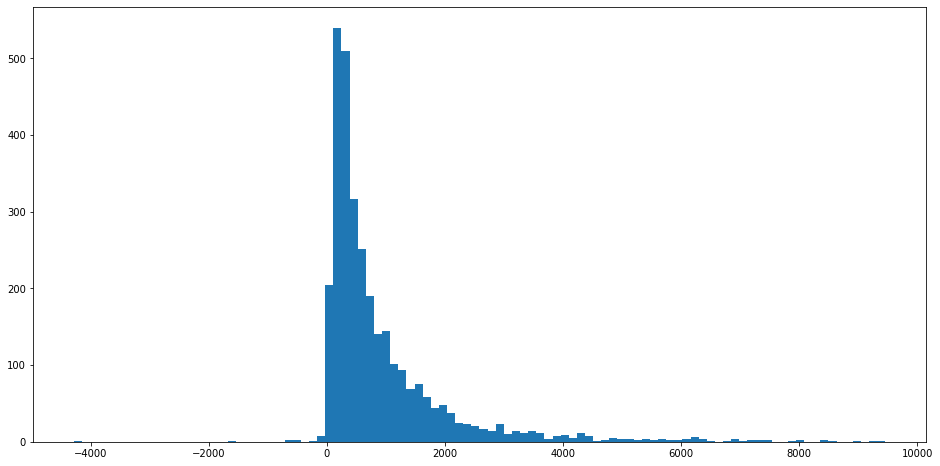

In [17]:
#plot LTV histogram
fig, ax = plt.subplots(figsize=(16,8))
plt.hist(data_user_6m[data_user_6m["m6_Revenue"]<10000]["m6_Revenue"],bins=100)
plt.show()

In [18]:
data_merge = pd.merge(data_user, data_user_6m, on='CustomerID', how='left')
data_merge = data_merge.fillna(0)
data_graph = data_merge.query("m6_Revenue < 30000")

Text(0, 0.5, 'm6_Revenue')

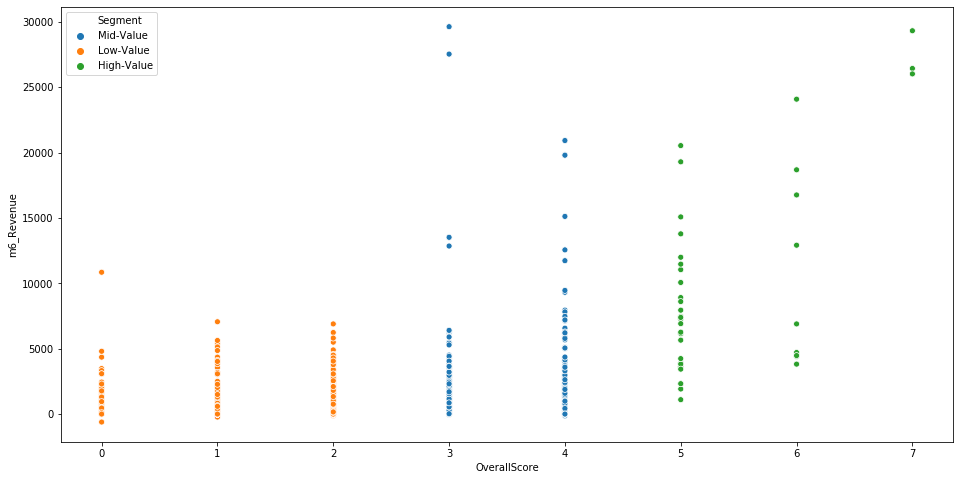

In [32]:
fig= plt.figure(figsize=(16,8))
sns.scatterplot(x="OverallScore",y="m6_Revenue",hue='Segment',data=data_graph)
plt.xlabel("OverallScore")
plt.ylabel("m6_Revenue")

In [20]:
# We can see positive correlation here. This means high RFM score means high LTV
#Model Selection 
#LTV itself is a regression problem however we'll be predictive each customer belongs to which of three segments Low,Mid or High
#LTV. We will use K-Means Clustering in order to classify the customers.
#remove outliers
data_merge = data_merge[data_merge['m6_Revenue']<data_merge['m6_Revenue'].quantile(0.99)]


#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_merge[['m6_Revenue']])
data_merge['LTVCluster'] = kmeans.predict(data_merge[['m6_Revenue']])

#order cluster number based on LTV
data_merge = order_cluster('LTVCluster', 'm6_Revenue',data_merge,True)

#creatinga new cluster dataframe
data_cluster = data_merge.copy()

#see details of the clusters
data_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


In [21]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
#convert categorical columns to numerical
data_class = pd.get_dummies(data_cluster)

#create X and y, X will be feature set and y is the label - LTV
X = data_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = data_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [22]:
#calculate and show correlations
corr_matrix = data_class.corr()
pd.DataFrame(corr_matrix['LTVCluster'].sort_values(ascending=False))

,LTVCluster
LTVCluster,1.000000
m6_Revenue,0.845933
Revenue,0.600491
RevenueCluster,0.467191
OverallScore,0.373114
FrequencyCluster,0.366366
Frequency,0.359601
Segment_High-Value,0.352387
RecencyCluster,0.236899
Segment_Mid-Value,0.168473


In [23]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.91
Accuracy of XGB classifier on test set: 0.76


In [24]:
y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        69
           1       0.42      0.26      0.32        19
           2       0.50      0.50      0.50         4

    accuracy                           0.76        92
   macro avg       0.58      0.56      0.56        92
weighted avg       0.73      0.76      0.74        92



In [25]:
data_class.groupby('LTVCluster').CustomerID.count()/data_class.CustomerID.count()

LTVCluster
0    0.765513
1    0.203734
2    0.030752
Name: CustomerID, dtype: float64

In [26]:
y_pred = ltv_xgb_model.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        69
           1       0.42      0.26      0.32        19
           2       0.50      0.50      0.50         4

    accuracy                           0.76        92
   macro avg       0.58      0.56      0.56        92
weighted avg       0.73      0.76      0.74        92

